# Using FluxEngine with in situ data

## Set the working directory
Before we do anything, we need to set the working directory to the root FluxEngine directory so that we know the relative location of the commandline tools we'll be using (just as we did in the previous tutorial). Again, it doesn't matter if you don't understand this code.

In [1]:
#This code changes the working directory from the tutorial folder to the root FluxEngine folder.
import os
if os.path.basename(os.getcwd()) != "FluxEngine":
    os.chdir(os.path.join("..",".."))
print "Working directory is now:", os.getcwd()

Working directory is now: /home/rr/Files/fluxengine_v3/FluxEngine


## Workflow for working with in situ data

The diagram below describes the workflow for working with in situ CO<sub>2</sub> data with FluxEngine, and consists of four steps. This assumes in situ data is provided as a text formatted file, for example tab or comma seperated value files.
<img src="images/insitu_workflow2.png" width="400">

<b>Step 1)</b> In situ fugacity of CO<sub>2</sub> (fCO<sub>2</sub>) measurements are often made from differing depths and can make use of different instrument setups. FluxEngine provides a tool which enables fCO<sub>2</sub> measurements to be reanalysed to a consistent temperature and depth field.

<b>Step 2)</b> Next the data must be converted into the gridded netCDF file format that FluxEngine uses. The `text2ncdf.py` tool can perform this conversion, and will automatically bin data into a specified grid resolution (calculating the mean and standard deviations where more than one data point falls into a single grid cell).

<b>Step 3)</b> With these netCDF files, FluxEngine can calculate the gas fluxes. This step uses the `ofluxghg_run.py` tool we've used in the previous tutorial.

<b>Step 4)</b> You'll now have calculated gas fluxes from the in situ data but they will be in a gridded format, rather than the original text format of the in situ data. FluxEngine provides a tool to convert netCDF output files into text files (`ncdf2text.py`) and another tool to directly append FluxEngine output variables to an existing text file (such as the original in situ data file), `append2insitu.py`.

This tutorial will demonstrate this process step by step.

## The data
We'll be working with the data collected from the AMT 2013 cruise. <b>TODO: describe data, give link and reference, plot cruise track...<\b> https://doi.pangaea.de/10.1594/PANGAEA.878492

<img src="images/kitidis_track.png" width="400">

## Step 1) Reanalysis CO<sub>2</sub> data to a consistent temperature and depth
The reanalysis tool can be run as a standalone commandline tool or by importing it as a Python module and including in a custom script. We will run it using the commandline tool. First, lets use the build-in help function to query the tool and see what options it provides.

In [5]:
!python fluxengine_src/tools/reanalyse_socat_driver.py -h

usage: reanalyse_socat_driver.py [-h] [-socat_dir SOCAT_DIR]
                                 [-socat_files [SOCAT_FILES [SOCAT_FILES ...]]]
                                 [-sst_dir SST_DIR] [-sst_tail SST_TAIL]
                                 [-output_dir OUTPUT_DIR] [-startyr STARTYR]
                                 [-endyr ENDYR]
                                 [-regions [<keyword_list> [<keyword_list> ...]]]
                                 [-withcoastal WITHCOASTAL] [-asciioutput]
                                 [-useaatsr] [-usereynolds] [-keepduplicates]
                                 [-keeptempfiles] [-socatversion SOCATVERSION]
                                 [-notsocatformat] [-year_col YEAR_COL]
                                 [-month_col MONTH_COL] [-day_col DAY_COL]
                                 [-hour_col HOUR_COL] [-minute_col MINUTE_COL]
                                 [-second_col SECOND_COL]
                                 [-longitude_col LONGITUDE_COL]

Notice that this follows the same syntax when we ran FluxEngine using the commandline tool in the previous tutorial; the `python fluxengine_src/tools/reanalyse_socat_driver.py` command tells the computer to run the reanalysis tool using Python, and then we supply a list of options (in this case a single option, `-h`, asking for the help information). This `-h` option ('h' standing for 'help') can be used with any of the FluxEngine commandline tools to view a built in description of the tool and its options.

Looking through the help message shows a lot of options, many of which are optional, or only occasionally used. Other options are always required, such as `socat_dir` and `-socat_files` which define the path to the input data (the word 'socat' is an artefact of the original use of the tool to reanalyse the SOCAT database), `-output_dir` which defines the directory that our reanalysed files will be saved to, and `-sst_dir` and `-sst_tail` which defined the path to a sea surface temperature climatology which will be used as the consistent temperature field. 

The tool is designed to be easily used with data that follow the format and column names of the SOCAT dataset, but our in situ data file isn't formatted exactly like this. We'll therefore also use the `-notsocatformat` option and specify the names of each of the required columns for time and date, longitude and latitude, salinity, in situ SST, air pressure and fCO<sub>2</sub>. The resulting command is long, but it's not complicated. We call the run the `reanalyse_socat_driver.py` tool using `python` and pass a series of options specifying the settings discussed above. Try running it now.

In [6]:
!python fluxengine_src/tools/reanalyse_socat_driver.py -socat_dir "Tutorials/02_using_insitu_data/insitu_data" -socat_files "kitidis_consistent.tsv" -output_dir "output/reanalysed/kitidis/" -usereynolds -sst_dir "Tutorials/02_using_insitu_data/reynolds_avhrr_only_monthly_calculated_tmh" -sst_tail "01_OCF-SST-GLO-1M-100-REYNOLDS_TMH.nc" -startyr 2013 -endyr 2013 -regions "kitidis" -asciioutput -notsocatformat -year_col "year" -month_col "month" -day_col "day" -hour_col "hour" -minute_col "minute" -second_col "second" -longitude_col "lon" -latitude_col "lat" -salinity_col "salinity" -salinity_sub_col "salinity_cl" -SST_C_col "temperature" -Tequ_col "temperature_eq" -air_pressure_col "air_pressure" -air_pressure_sub_col "air_pressure_cl" -air_pressure_equ_col "air_pressure_equ" -fCO2_col "fCO2water" -expocode_col 0


ATTENTION: selected to use Reynolds SST. This assumes that the sstdir points to the Reynolds data (if not you need to change it).

No interpolation option specified so will exit at interpolation stage.
Reading in data from SOCAT file: /home/rr/Files/fluxengine_v3/FluxEngine/Tutorials/02_using_insitu_data/insitu_data/kitidis_consistent.tsv
This can take a while for large datasets.

Subsetting data for year range: 2013 2013
num duplicates is:  0
/home/rr/anaconda2/lib/python2.7/site-packages/numpy/core/records.py:513: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))
Writing to: /home/rr/Files/fluxengine_v3/FluxEngine/fluxengine_src/tools/reanalyse_socat/output/reanalysed_data/10/kitidis_from_2013_to_2013_10_custom_insitu.txt

For convenience, lets perform one more step and merge the reanalysed fCO2 and SST climatology data into a single file. This is entirely optional but makes our work easier because we only need to perform the next steps on one file. The following Python script uses a library called Pandas to take the reanalysed data from October and November (this covers the entire period of the cruise) and joins them into one dataset, then adds the reanalysed data for temperature, partial pressure and fugacity into the original in situ data file. This combined file is then saved as a seperate file called `kitidis_reanalysed.tsv` which we will continue to work with in the next steps.

Don't worry if you don't understand the specifics of the Python code below. You could equally well do this step by hand in Excel, or by another programming language like R or Matlab.

In [12]:
import pandas as pd #allows using data frames
import numpy as np #matrix manipulation

#read the original in situ data and the reanalysed data.
#Note that the in situ data only covers October and November.
insituDf = pd.read_table("Tutorials/02_using_insitu_data/insitu_data/kitidis_consistent.tsv", sep="\t")
reanOct = pd.read_table("output/reanalysed/kitidis/output/reanalysed_data/10/kitidis_from_2013_to_2013_10_custom_insitu.txt", sep=",")
reanNov = pd.read_table("output/reanalysed/kitidis/output/reanalysed_data/11/kitidis_from_2013_to_2013_11_custom_insitu.txt", sep=",")

#Create and populate columns with each of the variables we want from the reanalysed data
#The first part of each column uses data from October and the second part uses data from November
#to create a continuous time series which is consistent with the in situ file.
SST_C = np.empty(len(insituDf)); #in situ SST
SST_C[0:len(reanOct)] = reanOct["SST_C"]
SST_C[len(reanOct):] = reanNov["SST_C"]

Tcl_C = np.empty(len(insituDf)); #consistent SST field data
Tcl_C[0:len(reanOct)] = reanOct["Tcl_C"]
Tcl_C[len(reanOct):] = reanNov["Tcl_C"]

fCO2_SST = np.empty(len(insituDf)); #in situ fCO2
fCO2_SST[0:len(reanOct)] = reanOct["fCO2_SST"]
fCO2_SST[len(reanOct):] = reanNov["fCO2_SST"]

fCO2_Tym = np.empty(len(insituDf)); #reanalysied fCO2
fCO2_Tym[0:len(reanOct)] = reanOct["fCO2_Tym"]
fCO2_Tym[len(reanOct):] = reanNov["fCO2_Tym"]

pCO2_SST = np.empty(len(insituDf)); #in situ pCO2
pCO2_SST[0:len(reanOct)] = reanOct["pCO2_SST"]
pCO2_SST[len(reanOct):] = reanNov["pCO2_SST"]

pCO2_Tym = np.empty(len(insituDf)); #reanalysed fCO2
pCO2_Tym[0:len(reanOct)] = reanOct["pCO2_Tym"]
pCO2_Tym[len(reanOct):] = reanNov["pCO2_Tym"]

#Add the reanalysed columns to the in situ data.
insituDf["SST_C"] = SST_C
insituDf["Tcl_C"] = Tcl_C
insituDf["fCO2_SST"] = fCO2_SST
insituDf["fCO2_Tym"] = fCO2_Tym
insituDf["pCO2_SST"] = pCO2_SST
insituDf["pCO2_Tym"] = pCO2_Tym

#Write merged dataframe to file
f = open("output/reanalysed/kitidis/kitidis_reanalysed.tsv", mode='w')
insituDf.to_csv(f, header=True, index=False, sep="\t", float_format='%.3f')
f.close();
print "Reanalysed data successfully merged."

Reanalysed data successfully merged.


## Step 2) Converting to netCDF format
FluxEngine requires input data in netCDF format which means we need to convert the text formated data into netCDF file(s). As before FluxEngine provides two ways to do this; the `text2ncdf.py` tool can be imported as a Python module or ran as a standalone commandline tool.

We'll continue using the commandline method. The tool requires a list of files to convert to netCDF (for us, this is just the single file we created in step 1), a start and stop time, a list of columns to convert into netCDF variables and output file path. The tool works by matching in situ measurements to a temporal and spatial grid, then calculating the mean value of all the measurements that are in a particular grid. Additionally the name (or index) of the date/time, longitude and latitude columns are also required because the tool uses this information to match in situ measurements to grid cells. Finally the spatial and temporal resolution must be specified. For our purposes we'll analyse the whole cruise together as a single time point, so we set the temporal resolution to 60 days (enough to span the period of the cruise), and the default spatial resolution of 1x1 degree will be more than adequate.

For more information on these settings you can view the help information by running the `text2ncdf.py` with the `-h` option. Run the command below

In [15]:
!python fluxengine_src/tools/text2ncdf.py "output/reanalysed/kitidis/kitidis_reanalysed.tsv" --startTime "2013-10-01 00:00:00" --endTime "2013-11-15 00:00:00" --ncOutPath "output/reanalysed/kitidis/kitidis_reanalysed.nc" --temporalResolution "60 00:00" --dateIndex 7 --cols 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 --latProd "lat" --lonProd "lon"

Parsing command line arguments.
Calculating dimensions.
The following columns will be extracted:
	temperature
	temperature_eq
	windspeed
	wind_moment2
	wind_moment3
	ice_coverage
	air_pressure
	air_pressure_equ
	air_pressure_cl
	salinity
	salinity_cl
	xCO2air
	fCO2water
	SST_C
	Tcl_C
	fCO2_SST
	fCO2_Tym
	pCO2_SST
	pCO2_Tym
Processing data in file output/reanalysed/kitidis/kitidis_reanalysed.tsv
Writing output netCDF file(s)...
Finished converting text file to netCDF3. There were 0 values which fell outside the specified lat/lon or start/stop time boundaries.
Number of missing values found: 6


If all goes well you'll see a message saying "Finished converting text file to netCDF3". You might see a message telling you there were 6 missing values. This isn't anything to worry about. <b>TODO: Why? Where do the missing values come from?? Explain!</b>

Lets open the netCDF file we've just created in Panoply to view its contents. You can find it in `output/reanalysed/kitidis/kitidis_reanalysed.nc`. You'll see that there are count, mean and standard deviation variables for each of the columns we converted. The count data stores the number of data points which were used to calculate the mean and standard deviation for each grid cell. Double click a few of the variables to plot them and check that they look sensible.

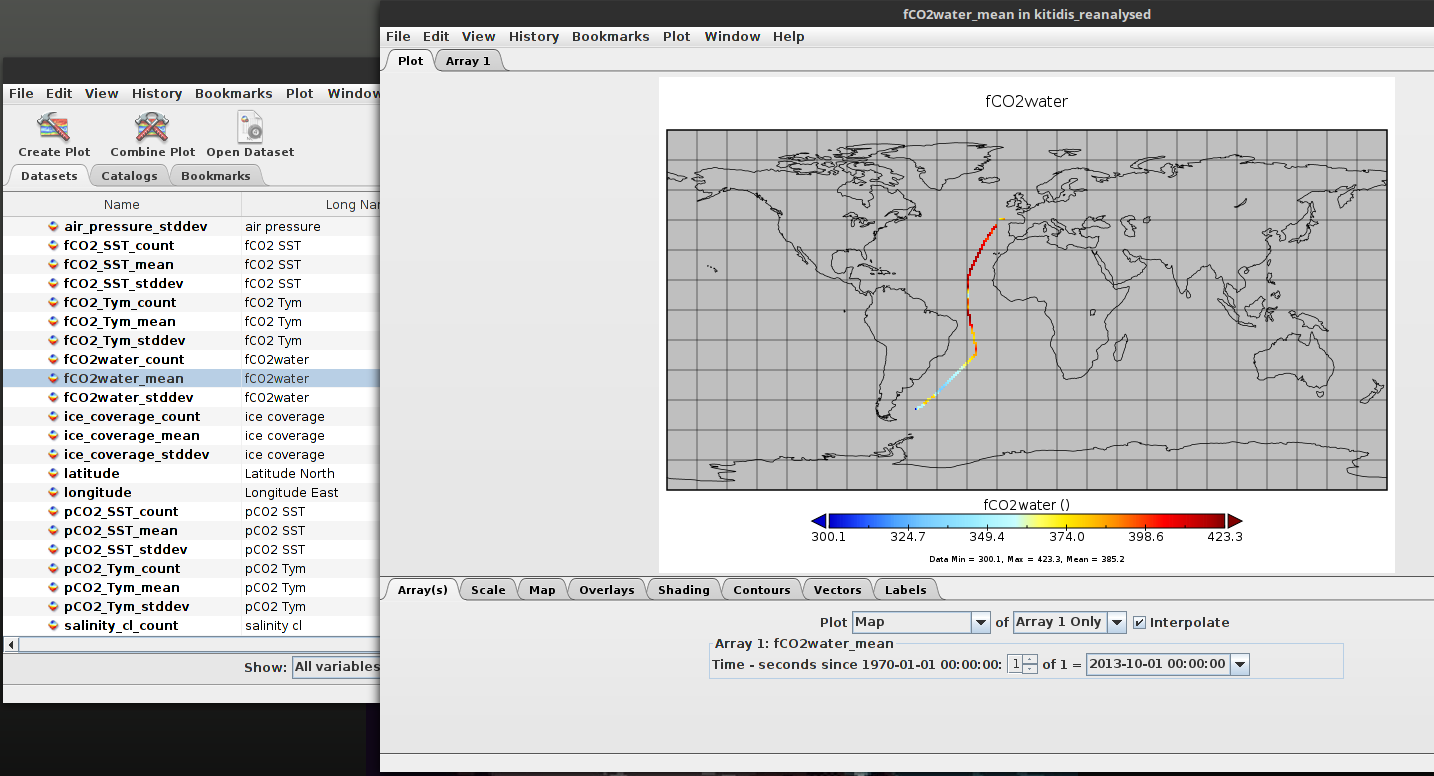

## Step 3) Running FluxEngine
We have our reanalysed data in netCDF format, now we can use FluxEngine to calculate the air-sea CO<sub>2</sub> fluxes!

We need to create a configuration file to tell FluxEngine to use our new netCDF file as input. For convenience this has been created for you (see the file stores at `Tutorials/02_using_insitu_data/kitidis_cruise_W14_reanalysed.conf`). The only significant difference between this configuration file, and the one you created in the first tutorial is the selected input data and the temporal resolution.

<i>Temporal resolution</i> - We want FluxEngine to calculate fluxes for the whole cruise track as a single file rather than as seperate monthly (or some other time step) files. To do this we use the `temporal_resolution` option, setting its value to `60 00:00` which indicates a timestep of 60 days, 0 hours and 0 minutes. This is a large enough interval of time to encompase the entire cruise, and so only a single time point will be generated.

<i>Input data</i> - Open the configuration file (`Tutorials/02_using_insitu_data/kitidis_cruise_W14_reanalysed.conf`) and scroll down to the section where input data is specified. You can see that for every input we're using the netCDF file we generated in step 2 and providing a different product name to access different variables within the netCDF file for the different inputs. Notice as well that we're using the reanalysed version of the fCO2 data (`fCO2_Tym_mean`) along with the sea surface temperature climatology (`Tcl_C_mean`).

Looking at the other settings you will see that we're using the 'rapid' flux equation and the Wanninkhof 2014 gas transfer parameterisation and Schmidt number parameterisation.

Lets calculate the air-sea CO<sub>2</sub> fluxes using the commandline tool we used in the previous tutorial:

In [24]:
!python ofluxghg_run.py "Tutorials/02_using_insitu_data/kitidis_cruise_W14_reanalysed.conf" -s "2013-10-01" -e "2013-11-15" -l

Executing on 'rr-HP-Compaq-Elite-8300-MT' at 22/05/2019 13:08:22
Parsing settings file at: /home/rr/Files/fluxengine_v3/FluxEngine/fluxengine_src/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (180, 360)
Converting sstfnd from celsius to kelvin.
/home/rr/Files/fluxengine_v3/FluxEngine/fluxengine_src/fe_core.py:1039: RuntimeWarning: invalid value encountered in less
  self.data["pco2_sw"].fdata[abs(self.data["pco2_sw"].fdata)<0.1]=DataLayer.missing_value#IGA_SOCATv4
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using SSTfnd data selection with correction for skin temperature (SSTskin = SSTfnd - 0)(ignoring SSTskin data in configuration file).
/home/rr/Files/fluxengine_v3/FluxEngine/fluxengine_src/fe_core.py:1263: RuntimeWarning: invalid value encountered in greater
  if npany(self.data["pressure"].fdata > 10000.0):
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_

Hopefully you'll see a "completed successfully" message at the end. Don't worry if you see some `RuntimeWarning`s about invalid values being encountered. This is because there are a few stray NaNs (not a number) in the data. FluxEngine will just ignore these and it won't affect the calculation.

Use Panoply to open the output netCDF file located in `output/kitidis_cruise/kitidis_W14_reanalysed.nc` and check that the output looks reasonable. Use Panoply to plot the air-sea flux (OF) variable, and the gas transfer velocity variable. Take the time to explore the output and visualise any others you might be interested in.

## Step 4) Combining FluxEngine output with in situ data and visualising
So far so good; we're reanalysed the in situ data fCO<sub>2</sub> data to a consistent temperature and depth, we've created a netCDF file containing our input data and used FluxEngine to calculate the gas fluxes. However, in many situtations calculating gas fluxes will be only one part of a wider analysis and it would be useful to extract variables from the FluxEngine output and put them back into our original in situ data file. Lets do this now.

As before, FluxEngine provides two way to do this; importing a module into a custom Python script or using a commandline tool, and as before we will use the commandline tool. The tool we'll use is called `append2insitu.py`, so lets run it with the `-h` help command to see how to use it.



In [25]:
!python fluxengine_src/tools/append2insitu.py -h

usage: append2insitu.py [-h] [--varsToAppend VARSTOAPPEND [VARSTOAPPEND ...]]
                        [--delim DELIM] [--latCol LATCOL] [--lonCol LONCOL]
                        [-m MISSINGVALUE] [--encoding ENCODING] [-d DATEINDEX]
                        [-n NUMCOMMENTLINES [NUMCOMMENTLINES ...]]
                        feOutput insituData outPath

Converts netCDF3 data produced as output from FluxEngine into text data (e.g.
csv, tsv). The text output will contain one column for each data layer, and
one row for each cell of the grid (if there is no missing data). One text file
will be created for each netCDF3 file.

positional arguments:
  feOutput              path to a FluxEngine output file
  insituData            path to a plain text in situ data file
  outPath               Path to store the produced text file.

optional arguments:
  -h, --help            show this help message and exit
  --varsToAppend VARSTOAPPEND [VARSTOAPPEND ...]
                        List of netCDF varia

These help files can take some practice to understand. Where it says 'positional arguments' it lists three mandatory pieces of information that the tool needs to run; `feOutput` which specifies the path to the FluxEngine output file, `insituData` which specifies the path to the in situ data file, and `outPath` which specifies path and name of the output file that will be created.

Next there is a list of 'optional arguments'. These are additional pieces of information that you can specify. They will often have default values (stated in the description of each optional argument) and specifying a different value simply overwrites the default. We'll use the `--varsToAppend` option to choose which FluxEngine output variables we would like to append to the in situ data. The tool uses the date, time and longitude and latitude fields to match up data from the in situ file and the FluxEngine output. We will therefore use the `--dateIndex` option to tell the tool which column in the in situ data contains the date information, and the `--lonCol` and `--latCol` options to specify the longitude and latitude column names.

Lets construct our commandline command and run it.

In [2]:
!python fluxengine_src/tools/append2insitu.py "output/kitidis_cruise/kitidis_W14_reanalysed.nc" "output/reanalysed/kitidis/kitidis_reanalysed.tsv" "output/kitidis_cruise/kitidis_W14_reanalysed_merged.tsv" --varsToAppend "OF" "OK3" "OSFC" "OIC1" --dateIndex 7 --lonCol "lon" --latCol "lat"

You should see a new text data file located here `output/kitidis_cruise/kitidis_W14_reanalysed_merged.tsv` that contains the original in situ data, the reanalysed fCO2 and pCO2 along with the SST climatology used to calculate it, and the FluxEngine outputs for air-sea flux (OF), gas transfer velocity (OK3), aqueous concentration of CO2 (OSFC) and interface concentration of CO2 (OIC1).

With all this data together in one file we can easily visualise it! The python code below will produce some time series plots, showing temperature (in situ and the consistent temperature field), wind speed, molar fraction of atmospheric CO<sub>2</sub> (xCO2), sub-skin and interface concentration of CO2 and the sea-to-air CO2 flux. Don't worry if you don't understand the Python code below - you could visualise the data using any visualisation tools you like. The important thing is to understand the main steps we've taken.

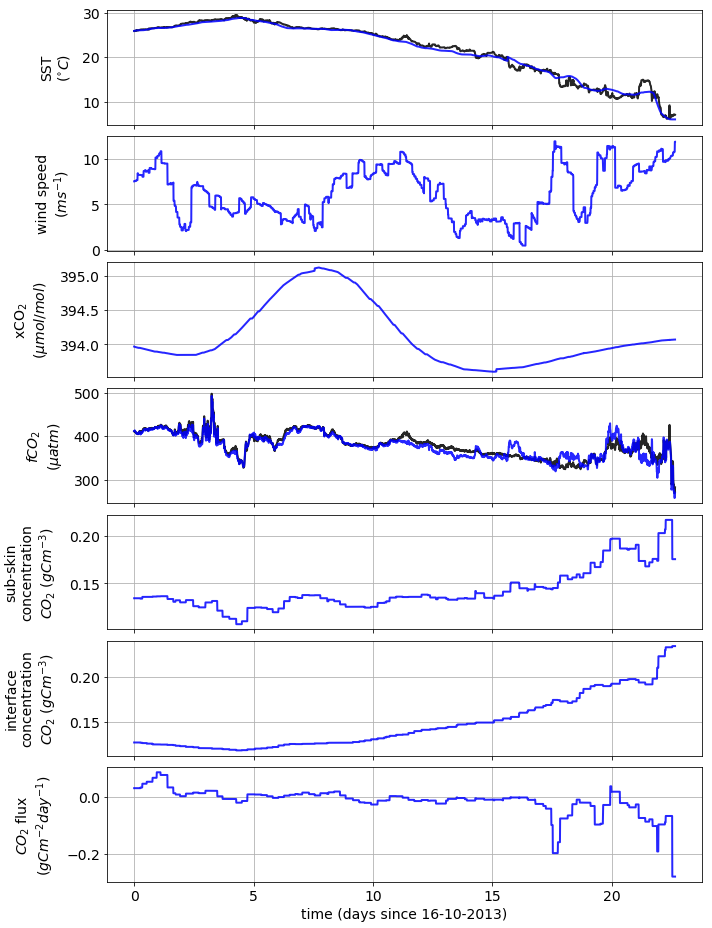

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime


#Returns time elapsed between baselineDate and date in days (fractions of days allowed).
def calc_fraction_days(baselineDate, date):
    delta = date-baselineDate;
    fractionDays = delta.days + (delta.seconds) / (24*60*60.0);
    return fractionDays;

#Time series plots
#Make a copy of the data kitidis
data = pd.read_table("output/kitidis_cruise/kitidis_W14_reanalysed_merged.tsv", sep="\t", parse_dates=[7])

#Rename columns to remove units for matplotlib to function correctly
newColNamesMap = {colName:colName.split('[')[0].strip() for colName in data.keys()};
data = data.rename(index=str, columns=newColNamesMap);

#Calculate time in fractions of days
baselineDate = datetime(2013, 10, 9); #First day of data in the kitidis dataset
time = [calc_fraction_days(baselineDate, d) for d in data["datetime"]];
data["fraction_days"] = time;
initialDiscard = 750; #Note that there's a problem with the xCO2 data. This just ignore the first section of the data for purely cosmetic reasons.
time = np.array(time) - time[initialDiscard];
time = time[initialDiscard:];

#Plotting settings
pad = 10; #padding between y axis and labels
rot = 90; #y label rotation
labelsize = 14;
ticksize = 14;

alpha = 0.85;
diffColour = (0.4, 0.4, 0.4);

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, sharex=True, sharey=False, figsize=[10,13]);
plt.xlabel("time (days since 16-10-2013)", fontsize=labelsize);
plt.tick_params(labelsize=ticksize);

ax1.plot(time, data["temperature"][initialDiscard:], 'k', linewidth=2, alpha=alpha, label="in situ"); #Temp [°C]
ax1.plot(time, data["Tcl_C"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="satellite"); #Temp [°C]
ax1.set_ylabel("SST\n($^{\circ}C$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax1.tick_params(labelsize=ticksize);
ax1.grid(True);    
    
ax2.plot(time, data["windspeed"][initialDiscard:], 'b', linewidth=2, alpha=alpha); #windspeed [m s-1]
ax2.set_ylabel("wind speed\n($ms^{-1}$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax2.tick_params(labelsize=ticksize);
ax2.grid(True);

ax3.plot(time, data["xCO2air"][initialDiscard:], 'b', linewidth=2, alpha=alpha); #xCO2air_interp [µmol/mol]
ax3.set_ylabel("xCO$_{2}$\n($\mu mol/mol$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax3.tick_params(labelsize=ticksize);
ax3.grid(True);
    
ax4.plot(time, data["fCO2_SST"][initialDiscard:], 'k', linewidth=2, alpha=alpha, label="in situ"); #fCO2water_SST_wet [µatm]
ax4.plot(time, data["fCO2_Tym"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="reanalysed"); #fCO2water_SST_wet [µatm]
ax4.set_ylabel("$fCO_{2}$\n($\mu atm$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax4.tick_params(labelsize=ticksize);
ax4.grid(True);

ax5.plot(time, data["OSFC"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="reanalysed"); #CO2 flux
ax5.set_ylabel("sub-skin\nconcentration\n$CO_{2}$ ($gCm^{-3}$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax5.tick_params(labelsize=ticksize);
ax5.grid(True);
    
ax6.plot(time, data["OIC1"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="reanalysed"); #CO2 flux
ax6.set_ylabel("interface\nconcentration\n$CO_{2}$ ($gCm^{-3}$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax6.tick_params(labelsize=ticksize);
ax6.grid(True);

ax7.plot(time, data["OF"][initialDiscard:], 'b', linewidth=2, alpha=alpha, label="reanalysed"); #CO2 flux
ax7.set_ylabel("$CO_{2}$ flux\n($gCm^{-2}day^{-1}$)", labelpad=pad, rotation=rot, fontsize=labelsize, horizontalalignment='center');
ax7.tick_params(labelsize=ticksize);
ax7.grid(True);
    
plt.tight_layout();
plt.subplots_adjust(hspace = 0.1);

## Next steps
These first two tutorials have covered the basics and you should be able to use the configuration files, commandline tools and workflow described in them as the basis to run your own air-sea gas flux calculations. There are three more tutorials which cover different aspects. You can do them in any order depending on your interest (and you probably won't be interested enough to do all of them).

 - Calculating air-sea CO<sub>2</sub> fluxes from a fixes station in the Baltic Sea
 - Calculating air-sea fluxes for N<sub>2</sub>O for an AMT cruise.
 - <b>Something else. Swedish lakes and freshwater stuff?</b>